# Feature Transformation Notebook

This notebook does the following:
- looks at the features present in the dataframe
- fits a normal curve to the top of it
- uses that centerpoint as a reference to mirror the left side over to the right
- perform a log transformation on the resultant data
- graphs the original and engineered features

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import math

import matplotlib.pyplot as plt
from matplotlib.figure import figaspect
from scipy import optimize
from scipy.stats import norm
from astropy import modeling

In [2]:
df = pd.read_excel('merged/merged.xlsx')

In [3]:
df.columns

Index(['Unnamed: 0', 'TotalLimno', 'ALLCYCADULTS', 'ALLCYCJUV', 'ALLCOPNAUP',
       'ALLROTIFERS', 'temp_c', 'specific_conductance', 'ph',
       'dissolved_o2_mg_l', 'turbidity', 'nitrate_nitrite', 'fChl',
       'organic_matter', 'salinity', 'dissolved_o2_percent_sat',
       '11_day_temp_c', '11_day_specific_conductance', '11_day_ph',
       '11_day_dissolved_o2_mg_l', '11_day_turbidity',
       '11_day_nitrate_nitrite', '11_day_organic_matter', '11_day_salinity',
       '11_day_dissolved_o2_percent_sat'],
      dtype='object')

In [4]:
df.drop(columns = ['Unnamed: 0'], inplace = True)
df

,TotalLimno,ALLCYCADULTS,ALLCYCJUV,ALLCOPNAUP,ALLROTIFERS,temp_c,specific_conductance,ph,dissolved_o2_mg_l,turbidity,...,dissolved_o2_percent_sat,11_day_temp_c,11_day_specific_conductance,11_day_ph,11_day_dissolved_o2_mg_l,11_day_turbidity,11_day_nitrate_nitrite,11_day_organic_matter,11_day_salinity,11_day_dissolved_o2_percent_sat
0,320,320,427,23482,9393,17.9,172,7.8,9.2,4.9,...,96,17.970135,195.824577,7.800000,9.149921,6.683658,0.301011,13.714064,0.100000,96.555515
1,187,187,934,16624,4483,17.9,198,7.8,9.2,6.2,...,97,18.012165,255.112062,7.740853,9.025867,9.532130,0.308989,14.078749,0.100000,95.258675
2,107,107,107,8432,5123,15.5,271,7.6,9.2,3.5,...,92,15.577728,252.405926,7.600881,9.199048,3.811088,0.498989,17.332461,0.100000,92.432097
3,427,427,107,5337,2775,15.6,258,7.6,9.2,3.6,...,92,15.600000,233.002626,7.609226,9.239091,3.404589,0.508989,18.017114,0.100000,92.817766
4,445,445,356,7027,5070,11.3,1280,7.6,9.9,6.8,...,91,11.300000,1210.804276,7.600000,9.900881,7.061364,0.638989,27.145784,0.589893,91.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,179877,179877,74448,572773,3122,21.1,14200,7.8,7.6,16.6,...,90,21.045924,13241.666803,7.841352,7.652946,20.303711,0.419983,23.374686,7.621958,90.155936
214,120493,120730,27751,513520,1660,21.1,14200,7.8,7.6,16.6,...,90,21.045924,13241.666803,7.841352,7.652946,20.303711,0.419983,23.374686,7.621958,90.155936
215,44162,44162,8405,103801,667,12.1,18200,7.5,9.4,22.3,...,94,12.148064,16765.213172,7.500000,9.505630,21.109991,0.583784,24.305620,9.796414,94.000000
216,17398,17398,4696,79305,534,12.1,18200,7.5,9.4,22.3,...,94,12.148064,16765.213172,7.500000,9.505630,21.109991,0.583784,24.305620,9.796414,94.000000


In [5]:
#sns.pairplot(df)

In [6]:
zoo_list = ['TotalLimno', 'ALLCYCADULTS', 'ALLCYCJUV', 'ALLCOPNAUP','ALLROTIFERS']
usgs_list = ['temp_c', 'specific_conductance', 'ph',
       'dissolved_o2_mg_l', 'turbidity', 'nitrate_nitrite', 'fChl',
       'organic_matter', 'salinity', 'dissolved_o2_percent_sat',
       '11_day_temp_c', '11_day_specific_conductance', '11_day_ph',
       '11_day_dissolved_o2_mg_l', '11_day_turbidity',
       '11_day_nitrate_nitrite', '11_day_organic_matter', '11_day_salinity',
       '11_day_dissolved_o2_percent_sat']

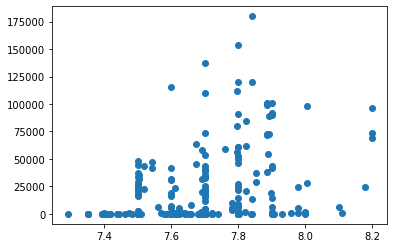

In [7]:
x, y = df['11_day_ph'], df['TotalLimno']
plt.scatter(x,y)

In [8]:
x_range = np.linspace(7,9,21)
x_range

array([7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8. , 8.1, 8.2,
       8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. ])

In [9]:
distribution = list(np.zeros(21))
for i,vals in enumerate(distribution[1:]):
    tempvallist = []
    #print(f'entry greater than: {x_range[i]} and less than: {x_range[i+1]}')
    for j, entry in enumerate(y):
        if (x[j]>x_range[i]) and (x[j]<=x_range[i+1]):
            tempvallist.append(entry)
            #print(f'entry greater than: {x_range[i]} and less than: {x_range[i+1]} \n entry: {entry}')
    if len(tempvallist) > 0:
        distribution[i] = max(tempvallist)
        #print(max(tempvallist))
    #print(tempvallist)
distribution

[0.0,
 0.0,
 0,
 934,
 48031,
 115853,
 137004,
 153937,
 179877,
 24496,
 98064,
 96285,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [10]:
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / 4 / stddev)**2)

#popt, _ = optimize.curve_fit(gaussian, x_range, distribution)
x_span = abs(x_range[-1]-x_range[0])

print([0.25*max(distribution),
                                  min(x_range)-2*x_span,
                                  0],
                                [max(distribution),
                                 max(x_range)+2*x_span,
                                 2*x_span])

popt, _ = optimize.curve_fit(gaussian, x_range, distribution,
                             bounds=(
                                [0.25*max(distribution),
                                  x_range[0]-2*x_span,
                                  0],
                                [max(distribution),
                                 x_range[-1]+2*x_span,
                                 4*x_span]))

[44969.25, 3.0, 0] [179877, 13.0, 4.0]


the mean and standard deviation of the fitted curve are: [7.7177997744156, 0.07934255366447379]



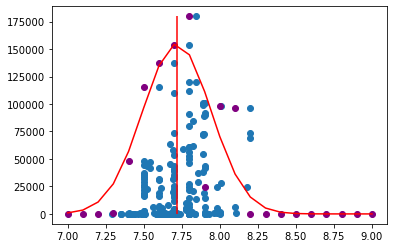

In [11]:
amplitude = popt[0]
mean = popt[1]
stddev = popt[2]
print(f'the mean and standard deviation of the fitted curve are: {[mean,stddev]}\n')

plt.scatter(x,y)
plt.scatter(x_range,distribution, color = 'purple')
plt.vlines(mean, ymin = 0, ymax = max(distribution), color='r')
plt.plot(x_range, gaussian(x_range, *popt), color='r');

In [12]:
df['transformed_11day_ph'] = -np.log(0.5*np.square((df['11_day_ph'] - mean)/stddev))
x2, y2 = df['transformed_11day_ph'], df['TotalLimno']

In [13]:
transformation_list = ['11_day_temp_c', '11_day_specific_conductance', '11_day_ph',
                       '11_day_dissolved_o2_mg_l', '11_day_turbidity',
                       '11_day_nitrate_nitrite', '11_day_organic_matter', '11_day_salinity',
                       '11_day_dissolved_o2_percent_sat']

working on:
	11_day_temp_c
the mean and standard deviation of the fitted curve are:
	[21.425699844202615, 1.2181990222017594]

working on:
	11_day_specific_conductance
the mean and standard deviation of the fitted curve are:
	[12275.945616152947, 2155.4824447834576]

working on:
	11_day_ph
the mean and standard deviation of the fitted curve are:
	[7.767838396103666, 0.04946771419846284]

working on:
	11_day_dissolved_o2_mg_l
the mean and standard deviation of the fitted curve are:
	[8.336239669483122, 0.15846745586504815]

working on:
	11_day_turbidity
the mean and standard deviation of the fitted curve are:
	[29.80404412731624, 6.448911681062043]

working on:
	11_day_nitrate_nitrite
the mean and standard deviation of the fitted curve are:
	[0.43730631006592147, 0.05051768435269166]

working on:
	11_day_organic_matter
the mean and standard deviation of the fitted curve are:
	[22.50354539395542, 1.636104656301617]

working on:
	11_day_salinity
the mean and standard deviation of the fitt

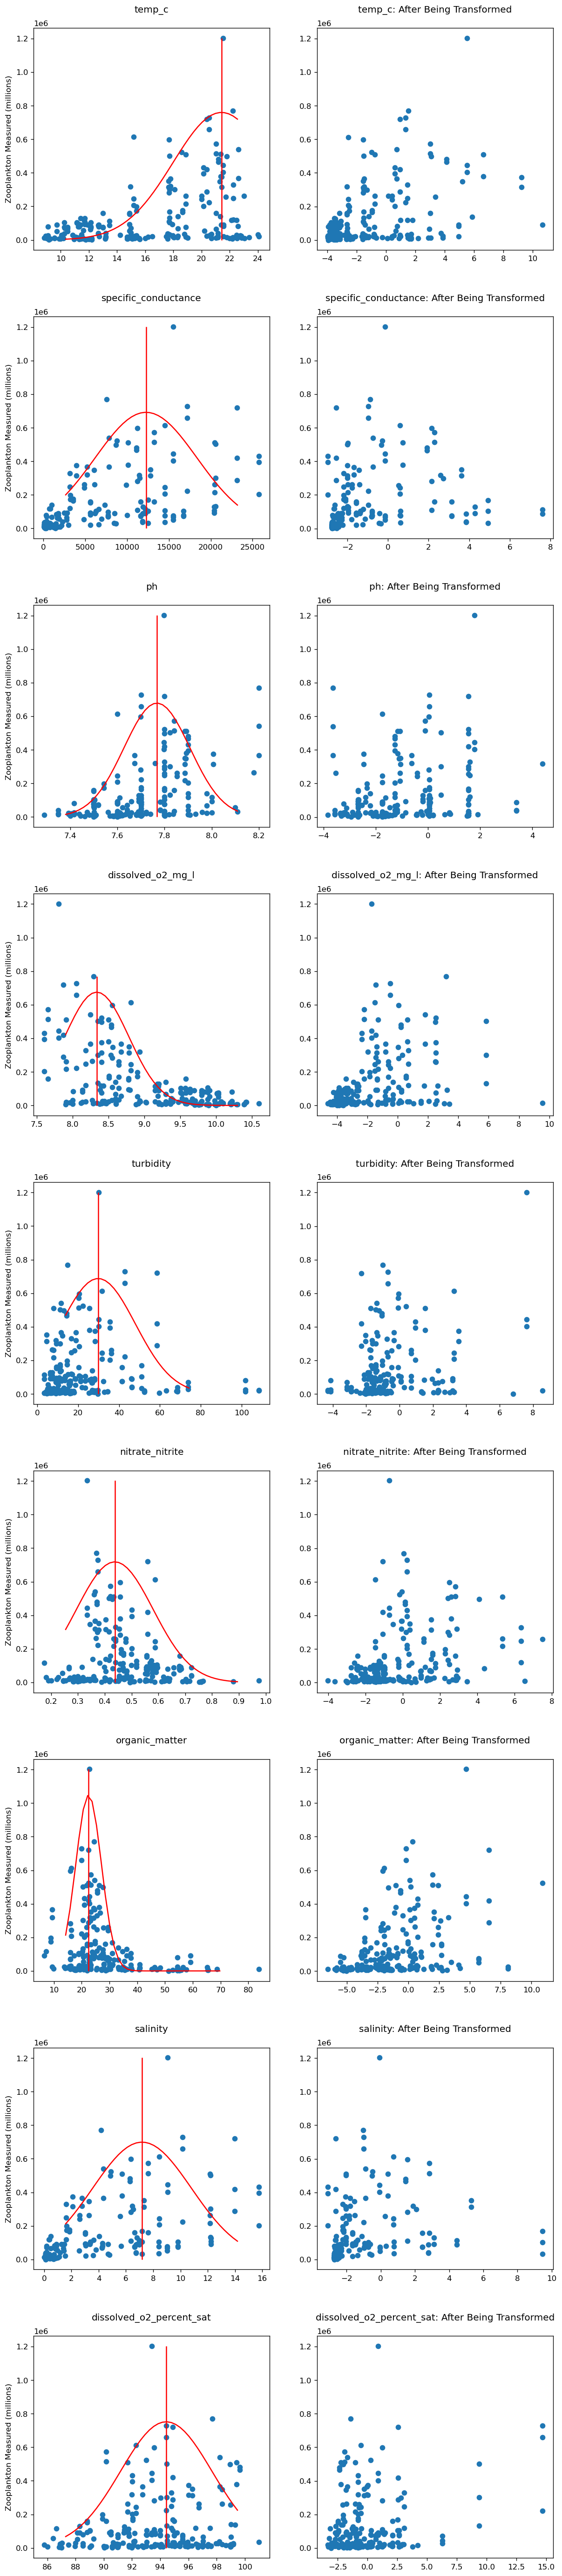

In [18]:
#species = 'TotalLimno', 'ALLCYCADULTS', 'ALLCYCJUV', 'ALLCOPNAUP','ALLROTIFERS'

w = 12
h = w*5
fig = plt.figure(figsize=(w,h), dpi = 120)
fig.subplots_adjust(hspace=0.3, wspace=0.2)

for plot_num, entry in enumerate(transformation_list):
    print(f'working on:\n\t{entry}')
    newcol = 'transformed_' + entry
    x, y = df[entry], df['ALLCOPNAUP']
    resolution = 40
    feature_range_center = ((max(df[entry]) + min(df[entry]))/2)
    
    feature_min = feature_range_center - 0.8*((max(df[entry]) - min(df[entry]))/2)
    feature_max = feature_range_center + 0.8*((max(df[entry]) - min(df[entry]))/2)
    
    top_cutoff = feature_range_center + (1-2/resolution)*((max(df[entry]) - min(df[entry]))/2)
    bottom_cutoff = feature_range_center - (1-2/resolution)*((max(df[entry]) - min(df[entry]))/2)
    
    x_range = list(np.linspace(feature_min,feature_max,resolution))
    distribution = list(np.zeros(resolution))
    
    #find the max values in each bin
    for i,vals in enumerate(distribution[1:]):
        tempvallist = []
        for j, y_val in enumerate(y):
            if (x[j]>x_range[i-1]) and (x[j]<=x_range[i+1]):
                tempvallist.append(y_val)
        if len(tempvallist) > 0:
            distribution[i] = max(tempvallist)
        
    for dist_index, dist_val in enumerate(distribution):
        left_val = distribution[dist_index-1]
        left_val_2 = 0
        if dist_index >= 2:#keeps left_val_2 from wrapping around the list
            left_val2 = distribution[dist_index-2]
            
        right_val_2 = 0
        if dist_index+2 < len(distribution):#keeps right_val_2 from calling an invalid index
            rightt_val2 = distribution[dist_index+2]
            
        try:
            right_val = distribution[dist_index+1]
        except:
            break
            
        if (dist_val < left_val) and (dist_val < right_val):
            distribution[dist_index] = (left_val + right_val)/2
        elif (dist_val < left_val) and (dist_val < right_val_2):
            distribution[dist_index] = (left_val + right_val)/2
            print('case2')
        elif (dist_val < left_val_2) and (dist_val < right_val):
            distribution[dist_index] = (left_val + right_val)/2
            print('case3')
        elif (dist_val < left_val_2) and (dist_val < right_val_2):
            distribution[dist_index] = (left_val + right_val)/2
            print('case4')
                   
    y_final = []
    x_final = []    

    for i in range(0,len(distribution), 1):
        if (distribution[i] > 5000):
            y_final.append(distribution[i])
            x_final.append(x_range[i])
        elif (i > top_cutoff) or (i < bottom_cutoff):
            y_final.append(distribution[i])
            x_final.append(x_range[i])
        
    plt.subplot(9,2,2*plot_num+1)
    plt.title(entry[7:], y=1.05)
    plt.ylabel('Zooplankton Measured (millions)')
    plt.scatter(x,y)
    #plt.scatter(x_final,y_final, color = 'purple')
    
    #def gaussian(x, amplitude, mean, stddev):
    #definition head to see which vars are being bounded
    x_range = x_final[-1] - x_final[0]
    popt, _ = optimize.curve_fit(gaussian, x_final, y_final, bounds=([200, x_final[0]-2*x_range, 0], [max(distribution), 2*x_range+x_final[-1], 2*x_range]))
    #fit a gaussian curve to the max values                  #bounding the amplitude, mean and stddev
            
    mean = popt[1]
    stddev = popt[2]
    print(f'the mean and standard deviation of the fitted curve are:\n\t{[mean,stddev]}\n')
    plt.vlines(mean, ymin = 0, ymax = max(distribution), color='r')#just put in an x value here to get the vertical line at that point
    plt.plot(x_final, gaussian(x_final, *popt), color='r')

    
    plt.subplot(9,2,2*plot_num+2)
    plt.title(entry[7:] + ': After Being Transformed',y=1.05)
    plt.scatter(-np.log(0.5*np.square((x - mean)/stddev)),y)
    
    df[newcol] = np.nan
    df[newcol] = -np.log(0.5*np.square((x - mean)/stddev))
df.columns
plt.savefig('feature_subplots.png')
